In [1]:
%load_ext autoreload
# %autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

from extract_field_0 import process_all_laser_files

from __init__ import FourierTransform, InverseFourierTransform, Fourier_filter
from calc_kernnel_johannes import IonProb, IonRate
#from calc_kernel_field_jit import IonRate_johannes as IonRateOldSchool





class AU:
    meter = 5.2917720859e-11 # atomic unit of length in meters
    nm = 5.2917721e-2 # atomic unit of length in nanometres
    second = 2.418884328e-17 # atomic unit of time in seconds
    fs = 2.418884328e-2 # atomic unit of time in femtoseconds
    Joule = 4.359743935e-18 # atomic unit of energy in Joules
    eV = 27.21138383 # atomic unit of energy in electronvolts
    Volts_per_meter = 5.142206313e+11 # atomic unit of electric field in V/m
    Volts_per_Angstrom = 51.42206313 # atomic unit of electric field in V/Angström
    speed_of_light = 137.035999 # vacuum speed of light in atomic units
    Coulomb = 1.60217646e-19 # atomic unit of electric charge in Coulombs
    PW_per_cm2_au = 0.02849451308 # PW/cm^2 in atomic units
AtomicUnits=AU

def Vector_potential(t,lam0, I, cep, FWHM, pi=np.pi, N=8): 
    """" return A(t) for given Full with half maximum and phase with a cos8 envelope  """
    w0=2*pi*137.035999/(lam0/5.2917721e-2)
    A0=np.sqrt(I/1e15*0.02849451308/w0**2)
    tau_injection=pi*FWHM/(4*np.arccos(2**(-1/(2*N))))
    t=np.asarray(t)
    # Field=np.zeros(np.shape(t))
    # cond=(abs(t)<=tau_injection)
    # t=t[cond]
    # Field[cond]=ne.evaluate("cos(pi*t/tau_injection/2)**N*sin(i*w0*t-cep)*A0")
    #Field= cos(pi*t/tau_injection/2)**N*sin(w0*t-cep)*A0  
    Field=np.where(np.abs(t)<=tau_injection,np.cos(pi*t/tau_injection/2)**N*np.sin(w0*t-cep)*A0,0)
    return Field

def Electric_Field(t,lam0, I, cep, FWHM, pi=np.pi, N=8): 
    """" return E(t) for given Full with half maximum and phase with a cos8 envelope  """
    #print('Electric_Field is deprecated, use Vector_potential instead')
    w0=2*pi*137.035999/(lam0/5.2917721e-2)
    A0=np.sqrt(I/1e15*0.02849451308/w0**2)
    tau_injection=pi*FWHM/(4*np.arccos(2**(-1/(2*N))))
    t=np.asarray(t)
    Field= np.where(np.abs(t)<=tau_injection,np.cos(pi*t/tau_injection/2)**N*np.cos(w0*t-cep)*w0-(N/2/tau_injection*pi*np.cos(pi*t/tau_injection/2)**(N-1)*np.sin(pi*t/tau_injection/2)*np.sin(w0*t-cep)),0)
    return -1*Field*A0

def analytical_rate(field, c1, e1, a1, a2, b1, b2, b3, p1, dTi, Ip):
    field=field+1e-20
    term1 = 1 / (2**(1/4) * (8 * e1**2 * field**2 + Ip)**(1/4) * abs(field)**(9/2)+1e-20)
    term2 = np.exp((4 * (np.sqrt(2) * np.sqrt(8 * e1**2 * field**2 + Ip) - 4 * e1 * abs(field)) * 
                    (-4 * e1**2 * field**2 - Ip + np.sqrt(2) * e1 * np.sqrt(8 * e1**2 * field**2 + Ip) * abs(field))) / 
                   (3 * abs(field)))
    term3 = field**2 * np.sqrt(np.pi)
    term4 = (dTi - 4 * e1 + (np.sqrt(2) * np.sqrt(8 * e1**2 * field**2 + Ip)) / abs(field))**-p1
    term5 = (a1 * field**4 + 8 * (-b1 * e1 * field**4 + 16 * a2 * e1**2 * field**6 - 256 * b2 * e1**3 * field**6 + 
                                  1024 * b3 * e1**4 * field**6 + a2 * field**4 * Ip - 24 * b2 * e1 * field**4 * Ip + 
                                  128 * b3 * e1**2 * field**4 * Ip + 2 * b3 * field**2 * Ip**2) - 
             16 * np.sqrt(2) * (-b2 + 8 * b3 * e1) * field**2 * (8 * e1**2 * field**2 + Ip)**(3/2) * abs(field) + 
             2 * np.sqrt(2) * (b1 - 16 * e1 * (a2 + 4 * e1 * (-3 * b2 + 8 * b3 * e1)) * field**2) * 
             np.sqrt(8 * e1**2 * field**2 + Ip) * abs(field)**3)
    
    return term1 * c1 * term2 * term3 * term4 * term5


process_all_laser_files('.', '/home/user/TIPTOE/850nm/350_nm_Drive_dense', 'output_interpol.csv', 'ionProb.csv', 'output_extract_field_0.csv')

process_all_laser_files('.', '/home/user/TIPTOE/850nm/350_nm_Drive_lower_Int', 'output_interpol_lowInt.csv', 'ionRate_lowInt.csv', 'output_extract_field_0_lowInt.csv')

File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/16/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/17/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/18/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/19/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/20/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/21/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/22/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/23/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/24/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/25/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/26/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/27/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/28/Laser
File not found: /home/user/TIPTOE/850nm/350_nm_Drive_lower_Int/2

In [5]:
%autoreload 2
data = pd.read_csv("/home/user/TIPTOE/ionProb.csv", header=None)
x = pd.to_numeric(data.iloc[2].iloc[2:].values)
y = pd.to_numeric(data.iloc[1].iloc[2:].values)

data_lower_Int = pd.read_csv("/home/user/TIPTOE/ionRate_lowInt.csv", header=None)
x_lower_Int = pd.to_numeric(data_lower_Int.iloc[2].iloc[2:].values)
y_lower_Int = pd.to_numeric(data_lower_Int.iloc[1].iloc[2:].values)

delay=x[:-1]
ion_y=y[:-1]

delay_lower_Int=x_lower_Int[:-1]
ion_y_lower_Int=y_lower_Int[:-1]

OptCycPump=850/AU.nm/AU.speed_of_light
tau_pump=np.pi*1*OptCycPump/(4*np.arccos(2**(-1/(2*8))))+10
time=np.arange(-int(tau_pump),int(tau_pump)+1,1.)

field_probe=lambda x : Electric_Field(time+x,350, 1e10, -np.pi/2, 0.93/AtomicUnits.fs, pi=np.pi, N=8)
field_pump= Electric_Field(time, 850, 1.25e+14, 0, 1*OptCycPump, pi=np.pi, N=8)

field_probe_lower_Int=lambda x : Electric_Field(time+x,350, 1e10*0.6, -np.pi/2, 0.93/AtomicUnits.fs, pi=np.pi, N=8)
field_pump_lower_Int= Electric_Field(time, 850, 1.25e+14*0.6, 0, 1*OptCycPump, pi=np.pi, N=8)

field_probe_higher_Int=lambda x : Electric_Field(time+x,350, 4e10*1.4, -np.pi/2, 0.93/AtomicUnits.fs, pi=np.pi, N=8)
field_pump_higher_Int= Electric_Field(time, 850, 5e+14*1.4, 0, 1*OptCycPump, pi=np.pi, N=8)



# plt.plot(time, field_probe)
# plt.plot(time, field_pump(100))
Ipot=0.5
dTi = 1
p1 = 3.5
a1 = 1
b2 = 1
gamma= 3/(2*Ipot)
c1=111.927
b3=0.970771
e1 = 1 + 1/Ipot/2
b1 = -0.25 + 0.75/Ipot
a2 = (-7.5 + 30*Ipot - 37.5*Ipot**2 + 15*Ipot**3) / 7.5

#ion_nonAdiabatic_oldSchool=np.real(IonRateOldSchool(time, dT=0.0078125, wavel=850, E0=max(abs(field_pump)), cep=0, fwhmau=1*OptCycPump,c1=111.927, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot,e2=1/36, e2n=30, e2d=2,b4=-16/9*b3))

#ion_nonAdiabatic_oldSchool=np.real(IonRateOldSchool(time, time, field_pump, c1=111.927, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot,e2=1/36, e2n=30, e2d=2,b4=-16/9*b3))

ion_nonAdiabatic=np.real(IonRate(time, time, field_pump, c1=111.927, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot,e2=1/36, e2n=30, e2d=2,b4=-16/9*b3))

ion_nonAdiabatic_higher_Int=np.real(IonRate(time, time, field_pump_higher_Int, c1=111.927, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot,e2=1/36, e2n=30, e2d=2,b4=-16/9*b3))

ion_nonAdiabatic_lower_Int=np.real(IonRate(time, time, field_pump_lower_Int, c1=111.927, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot,e2=1/36, e2n=30, e2d=2,b4=-16/9*b3))


ion_analytical=analytical_rate(field_pump, c1, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot)

ion_analytical_lower_Int=analytical_rate(field_pump_lower_Int, c1, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot)

ion_analytical_higher_Int=analytical_rate(field_pump_higher_Int, c1, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot)

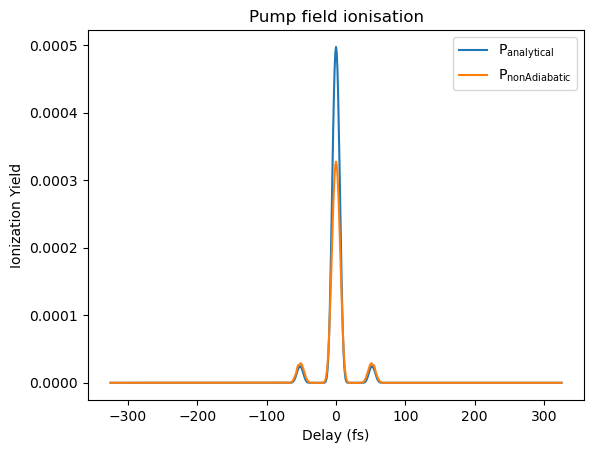

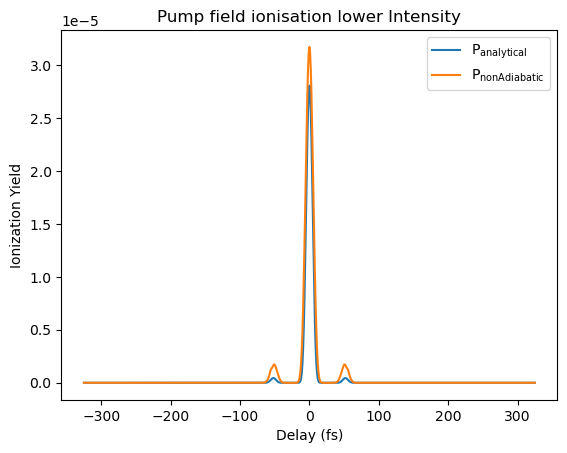

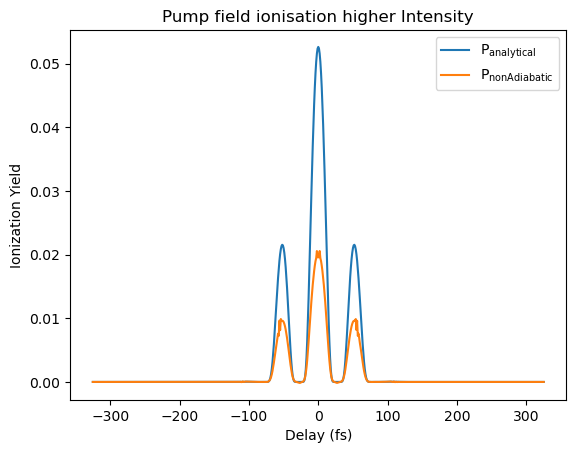

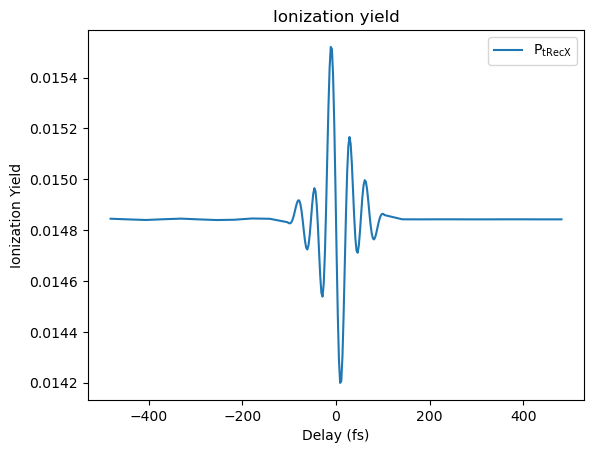

In [6]:
plt.plot(time, ion_analytical, label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$')
plt.plot(time, ion_nonAdiabatic, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
plt.xlabel('Delay (fs)')
plt.ylabel('Ionization Yield')
plt.title('Pump field ionisation')
plt.legend()
plt.show()
plt.close()

plt.plot(time, ion_analytical_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$')
plt.plot(time, ion_nonAdiabatic_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
plt.ylabel('Ionization Yield')
plt.xlabel('Delay (fs)')
plt.title('Pump field ionisation lower Intensity')
plt.legend()
plt.show()
plt.close()

plt.plot(time, ion_analytical_higher_Int, label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$')
plt.plot(time, ion_nonAdiabatic_higher_Int, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
plt.ylabel('Ionization Yield')
plt.xlabel('Delay (fs)')
plt.title('Pump field ionisation higher Intensity')
plt.legend()
plt.show()
plt.close()

plt.plot(delay, ion_y, label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
#plt.plot(delay, ion_y_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{tRecX, low}}$')
plt.xlabel('Delay (fs)')
plt.ylabel('Ionization Yield')
plt.title('Ionization yield')
plt.legend()
plt.show()
plt.close()

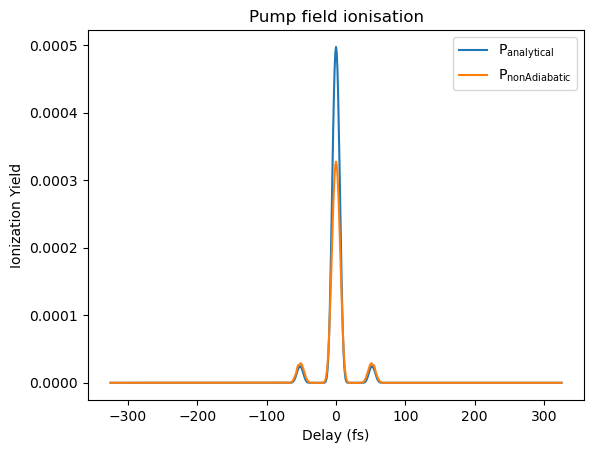

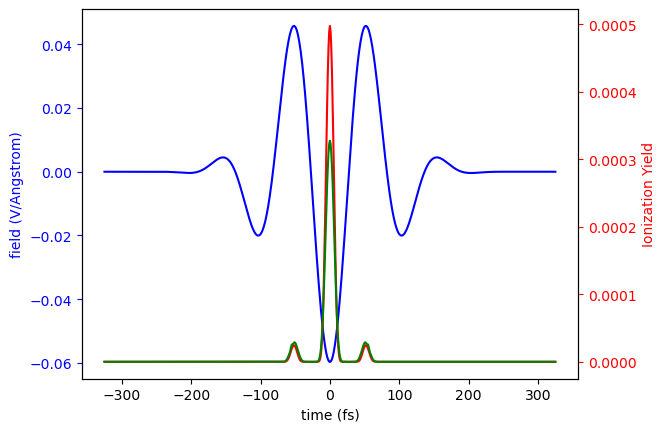

In [7]:
# from importlib import reload
# reload(Ionrate)
# %load_ext autoreload
# %autoreload 2
# ion_nonAdiabatic_oldSchool=np.real(IonRateOldSchool(time, time, field_pump, c1=111.927, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot,e2=1/36, e2n=30, e2d=2,b4=-16/9*b3))

# ion_nonAdiabatic=np.real(IonRate(time, time, field_pump, c1=111.927, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot,e2=1/36, e2n=30, e2d=2,b4=-16/9*b3))


plt.plot(time, analytical_rate(field_pump, c1, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot), label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$')
plt.plot(time, ion_nonAdiabatic, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
#plt.plot(time, ion_nonAdiabatic_oldSchool, label='P_nonAdiabatic_oldSchool')
plt.xlabel('Delay (fs)')
plt.ylabel('Ionization Yield')
plt.title('Pump field ionisation')
plt.legend()
#ax2=plt.twinx()
#ax2.plot(time, field_pump**2, color='grey', alpha=0.5, label='E²')
#ax2.set_ylabel('E²')
#plt.legend(loc='upper left')
#plt.savefig('pump_field_ionisation_yield.png', dpi=300)
plt.show()
plt.close()
# plt.plot(time, field_pump)
# plt.show()
# plt.close()
fig, ax1 = plt.subplots()
ax1.plot(time, field_pump, 'b-')
ax1.set_xlabel('time (fs)')
ax1.set_ylabel('field (V/Angstrom)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(time, analytical_rate(field_pump, c1, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot), label=rf'$\mathrm{{P}}_\mathrm{{analytical}}$', color='r')
ax2.set_ylabel('Ionization Yield', color='r')
ax2.tick_params('y', colors='r')
ax2.plot(time, ion_nonAdiabatic, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$', color='g')
plt.show()
plt.close()


In [13]:
fieldTotDel= lambda x : field_pump+field_probe(x)

Ipot=0.5
dTi = 1
p1 = 3.5
a1 = 1.
b2 = 1.
gamma= 3/(2*Ipot)
c1=111.927
b3=0.970771
e1 = 1 + 1/Ipot/2
b1 = -0.25 + 0.75/Ipot
a2 = (-7.5 + 30*Ipot - 37.5*Ipot**2 + 15*Ipot**3) / 7.5
an_Prob=lambda x : [1-np.exp(-np.trapz(analytical_rate(fieldTotDel(tau), c1, e1=gamma/2*e1, a1=0*4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot),time)) for tau in x]
noAdiabatic_prob=lambda x : [1-np.exp(-IonProb(time, fieldTotDel(tau),c1, e1=gamma/2*e1, a1=4*gamma*a1, a2=4*gamma**2*a2, b1=b1, b2=2*gamma*b1*b2, b3=b3, p1=p1, dTi=2*gamma*dTi, Ip=Ipot,e2=1/36, e2n=30, e2d=2,b4=-16/9*b3)) for tau in x]



#plt.plot(tau_x, ion_y)
#plt.plot(tau_x, field_y)
ion_QS=an_Prob(delay)
ion_na=noAdiabatic_prob(delay)


# x = pd.to_numeric(data.iloc[2].iloc[2:].values)
# y = pd.to_numeric(data.iloc[1].iloc[2:].values)
# delay=x[:-1]
# ion_y=y[:-1]

/home/user/TIPTOE/calc_kernnel_johannes.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.double(prob)


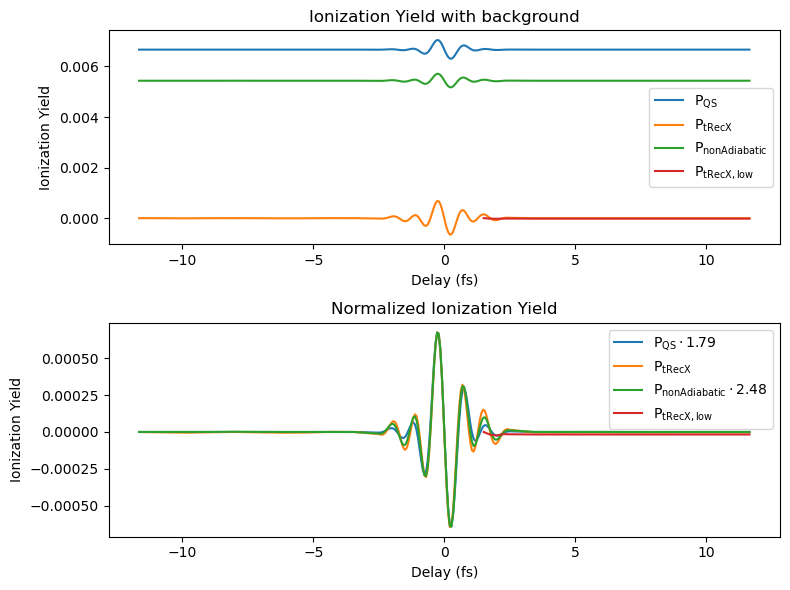

In [14]:


#plt.plot(tau_x, ion_y)
#plt.plot(tau_x, field_y)data = pd.read_csv("/home/user/TIPTOE/ionProb.csv", header=None)


# plt.plot(delay*AU.fs, ion_QS, label=rf'$\mathrm{{P}}_\mathrm{{QS}}$')
# plt.plot(delay*AU.fs, ion_y, label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
# plt.plot(delay*AU.fs, ion_na, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
# plt.ylabel('Ionization Yield')
# plt.xlabel('Delay (fs)')
# plt.title('Ionization Yield with background')
# plt.legend()
# plt.show()
# plt.close()



# plt.plot(delay*AU.fs, ion_QS/max(abs(ion_QS))*max(abs(ion_y)), label=rf'$\mathrm{{P}}_\mathrm{{QS}}\cdot${max(abs(ion_y))/max(abs(ion_QS)):.2f}')#/max(abs(ion_QS))*max(abs(ion_y))
# plt.plot(delay*AU.fs, ion_y, label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
# plt.plot(delay*AU.fs, ion_na/max(abs(ion_na))*max(abs(ion_y)), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}\cdot${max(abs(ion_y))/max(abs(ion_na)):.2f}')
# plt.xlabel('Delay (fs)')
# plt.ylabel('Ionization Yield')
# plt.legend()
# plt.title('Normalized Ionization Yield')
# plt.show()
# plt.close()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(delay*AU.fs, ion_QS, label=rf'$\mathrm{{P}}_\mathrm{{QS}}$')
ax1.plot(delay*AU.fs, ion_y, label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax1.plot(delay*AU.fs, ion_na, label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
ax1.plot(delay_lower_Int*AU.fs, ion_y_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{tRecX, low}}$')

ax1.set_ylabel('Ionization Yield')
ax1.set_xlabel('Delay (fs)')
ax1.set_title('Ionization Yield with background')
ax1.legend()

ion_na=ion_na-ion_na[-1]
ion_QS=ion_QS-ion_QS[-1]
ion_y=ion_y-ion_y[-1]
ion_y_lower_Int=ion_y_lower_Int-ion_y_lower_Int[-1]

ax2.plot(delay*AU.fs, ion_QS/max(abs(ion_QS))*max(abs(ion_y)), label=rf'$\mathrm{{P}}_\mathrm{{QS}}\cdot${max(abs(ion_y))/max(abs(ion_QS)):.2f}')#/max(abs(ion_QS))*max(abs(ion_y))
ax2.plot(delay*AU.fs, ion_y, label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax2.plot(delay*AU.fs, ion_na/max(abs(ion_na))*max(abs(ion_y)), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}\cdot${max(abs(ion_y))/max(abs(ion_na)):.2f}')
ax2.plot(delay_lower_Int*AU.fs, ion_y_lower_Int, label=rf'$\mathrm{{P}}_\mathrm{{tRecX, low}}$')
ax2.set_xlabel('Delay (fs)')
ax2.set_ylabel('Ionization Yield')
ax2.legend()
ax2.set_title('Normalized Ionization Yield')

plt.tight_layout()
#plt.savefig('ionization_yield_background_and_normalized.png', dpi=300)    
plt.show()
plt.close()


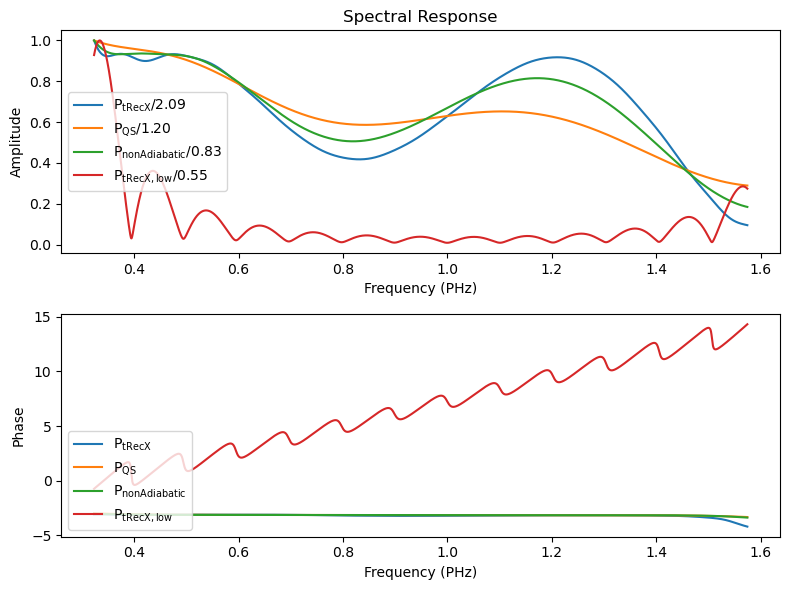

In [16]:

ion_na=ion_na-ion_na[-1]
ion_QS=ion_QS-ion_QS[-1] #is this a problem? because the backgorund is subtracted 2 times, i dont know if the variables change above gobally
ion_y=ion_y-ion_y[-1]
ion_y_lower_Int=ion_y_lower_Int-ion_y_lower_Int[-1]

field_probe_2 = field_probe(0)
field_probe_fourier, omega = FourierTransform(time*AU.fs, field_probe_2, t0=0)
field_probe_fourier=field_probe_fourier.flatten()
omega=omega[abs(field_probe_fourier)*20>max(abs(field_probe_fourier))]
omega=omega[omega>0]
omega=np.linspace(omega[0], omega[-1], 5000)
field_probe_fourier = FourierTransform(time*AU.fs, field_probe_2, omega, t0=0)

e2 = 1
e2d = 1
e2n = 1
b4 = 1
Ip = 1

ion_QS_fourier = FourierTransform(delay[::-1]*AU.fs, ion_QS[::-1], omega, t0=0)
ion_y_fourier = FourierTransform(delay[::-1]*AU.fs, ion_y[::-1], omega, t0=0)
ion_nonAdiabatic_fourier = FourierTransform(delay[::-1]*AU.fs, ion_na[::-1], omega, t0=0)
ion_y_lower_Int_fourier = FourierTransform(delay_lower_Int[::-1]*AU.fs, ion_y_lower_Int[::-1], omega, t0=0)
ion_QS_resp=ion_QS_fourier/field_probe_fourier
ion_y_resp=ion_y_fourier/field_probe_fourier
ion_nonAdiabatic_resp=ion_nonAdiabatic_fourier/field_probe_fourier
ion_y_lower_Int_resp=ion_y_lower_Int_fourier/field_probe_fourier


# ion_nonAdiabatic_fourier = FourierTransform(time*AU.fs, ion_nonAdiabatic, omega, t0=0)
# ion_nonAdiabatic_resp=ion_nonAdiabatic_fourier#/field_probe_fourier



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))


ax1.plot(omega/2/np.pi, np.abs(ion_y_resp)/np.abs(ion_y_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$/{np.abs(ion_y_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_QS_resp)/np.abs(ion_QS_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$/{np.abs(ion_QS_resp).max():.2f}') 
ax1.plot(omega/2/np.pi, np.abs(ion_nonAdiabatic_resp)/np.abs(ion_nonAdiabatic_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$/{np.abs(ion_nonAdiabatic_resp).max():.2f}')
ax1.plot(omega/2/np.pi, np.abs(ion_y_lower_Int_resp)/np.abs(ion_y_lower_Int_resp).max(), label=rf'$\mathrm{{P}}_\mathrm{{tRecX, low}}$/{np.abs(ion_y_lower_Int_resp).max():.2f}')

ax1.set_xlabel('Frequency (PHz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Spectral Response')
ax1.legend()

ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_y_resp)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_QS_resp)), label=rf'$\mathrm{{P}}_\mathrm{{QS}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_nonAdiabatic_resp)), label=rf'$\mathrm{{P}}_\mathrm{{nonAdiabatic}}$')
ax2.plot(omega/2/np.pi, np.unwrap(np.angle(ion_y_lower_Int_resp)), label=rf'$\mathrm{{P}}_\mathrm{{tRecX, low}}$')

ax2.set_xlabel('Frequency (PHz)')
ax2.set_ylabel('Phase')
ax2.legend(loc='lower left')

fig.tight_layout()
#plt.savefig('spectral_response_amplitude_phase.png', dpi=300)
plt.show()
plt.close()



# plt.plot(omega/2/np.pi, np.abs(ion_y_fourier)/np.abs(ion_y_fourier).max(), label='P_tRecX')
# plt.plot(omega/2/np.pi, np.abs(ion_QS_fourier)/np.abs(ion_QS_fourier).max(), label='P_QS')

#plt.plot(time, np.abs(field_probe_fourier[0][:1001]))
#plt.plot(np.abs(field_probe_fourier[1]), np.abs(field_probe_fourier[0]))

# plt.plot(time, np.abs(ion_QS_fourier[0][:1001]))
# plt.show()
# plt.close()